## CNN Autoencoder stuff

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
# Define the model architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.stride = 2
        self.pad = 1
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=self.stride, padding=self.pad),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=self.stride, padding=self.pad),
            nn.ReLU(),
            # nn.Conv2d(12, 8, kernel_size=3, stride=self.stride, padding=self.pad),
            # nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=3, stride=self.stride, padding=self.pad),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=self.stride, padding=self.pad, output_padding=self.stride-1),
            nn.ReLU(),
            # nn.ConvTranspose2d(8, 12, kernel_size=3, stride=self.stride, padding=self.pad, output_padding=self.stride-1),
            # nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=self.stride, padding=self.pad, output_padding=self.stride-1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=self.stride, padding=self.pad, output_padding=self.stride-1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        return x


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()

        # Downsample
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)

        # Upsample
        self.up1 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)

        # Output
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Downsample
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)

        # Upsample
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)

        # Output
        x = self.out(x)
        return x


In [ ]:
# Load the CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

VERBOSE = 1
nums = 10

100%|██████████| 170498071/170498071 [00:05<00:00, 29351410.96it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))




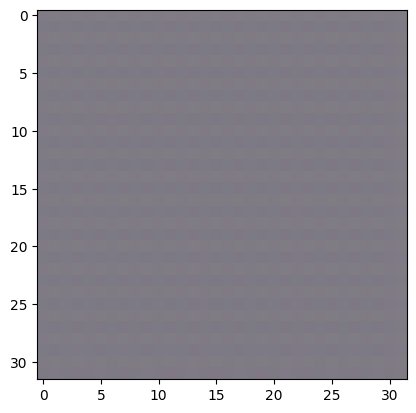

In [ ]:
plt.imshow(output[-1].cpu().detach().numpy().transpose(1, 2, 0))

In [ ]:
a = model.encoder(img[-1])
print(a.shape)

torch.Size([4, 6, 6])


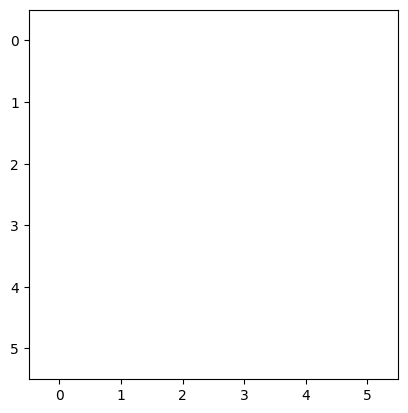

In [ ]:
plt.imshow(a.cpu().detach().numpy().transpose(1, 2, 0))

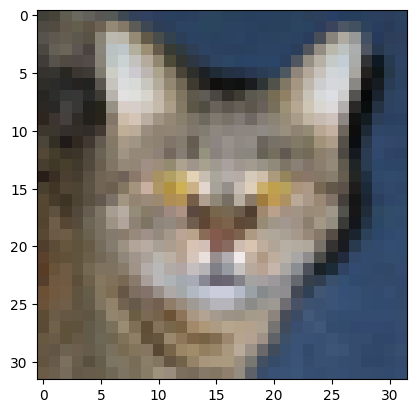

In [ ]:
plt.imshow(img[-1].cpu().detach().numpy().transpose(1, 2, 0))

Files already downloaded and verified
Latent vector:  torch.Size([4, 4, 32, 32])


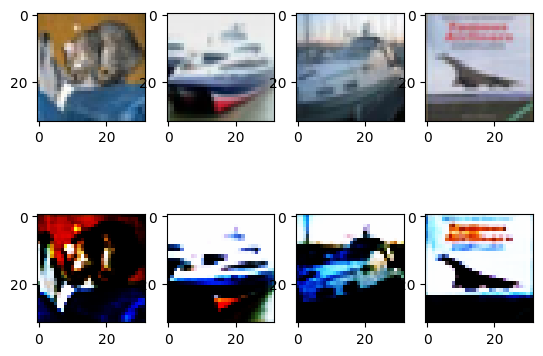

Latent vector:  torch.Size([4, 4, 32, 32])


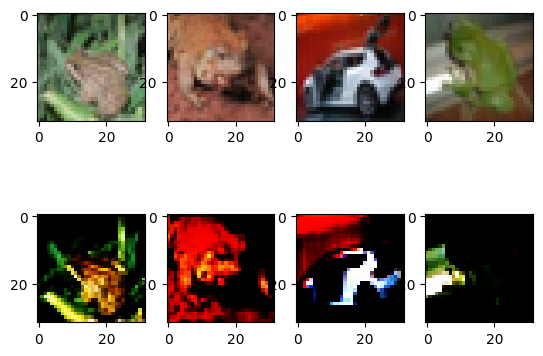

Latent vector:  torch.Size([4, 4, 32, 32])


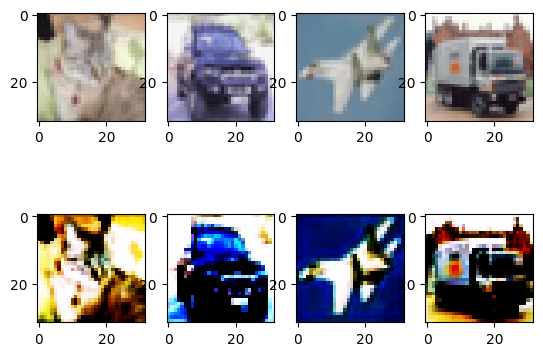

Latent vector:  torch.Size([4, 4, 32, 32])


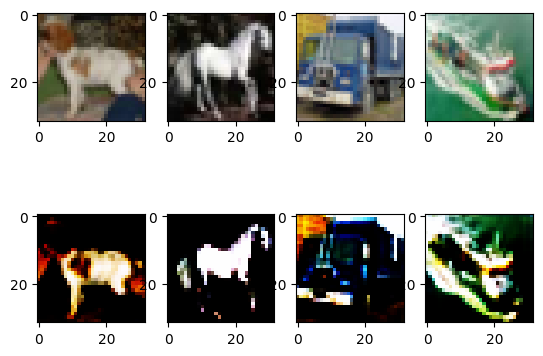

Latent vector:  torch.Size([4, 4, 32, 32])


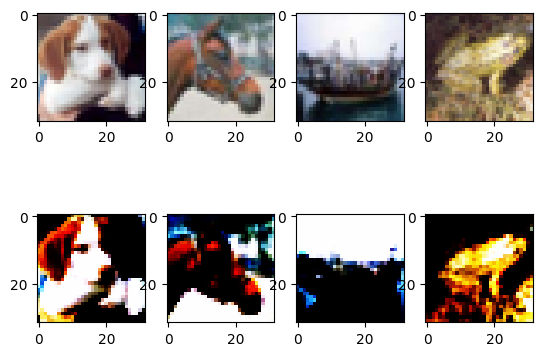

Latent vector:  torch.Size([4, 4, 32, 32])


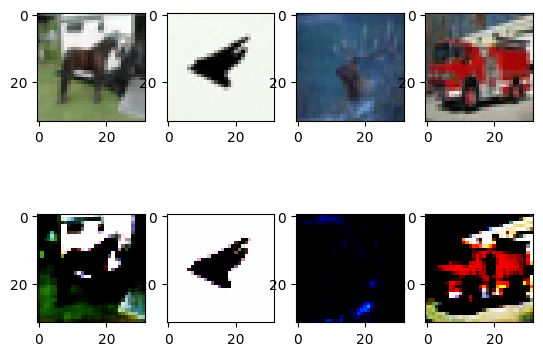

Latent vector:  torch.Size([4, 4, 32, 32])


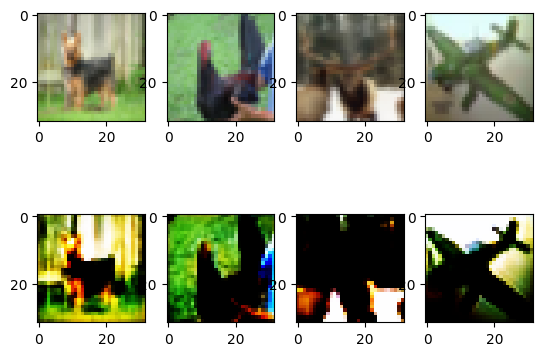

Latent vector:  torch.Size([4, 4, 32, 32])


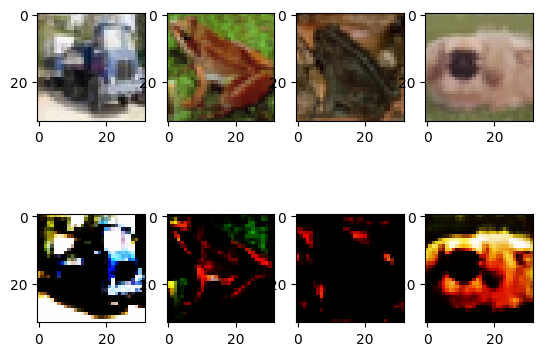

Latent vector:  torch.Size([4, 4, 32, 32])


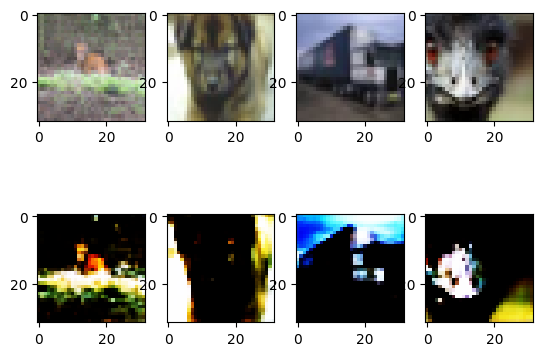

Latent vector:  torch.Size([4, 4, 32, 32])


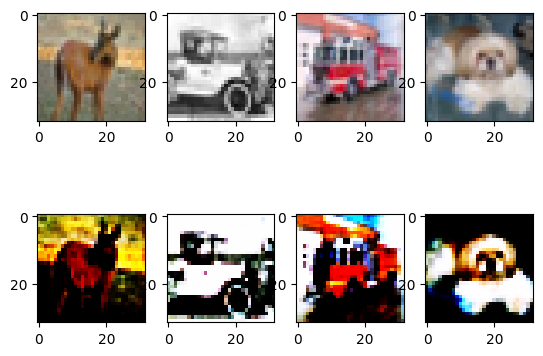

In [ ]:
if VERBOSE == 1:
  count = 0

  # Test the model on a few images
  test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)
  with torch.no_grad():
      for data in test_loader:
          if count < nums:
              img, _ = data
              img = img.to(device)
              output = model(img)
              print("Latent vector: ", model.encoder(img).shape)
              output = output.cpu()
              img = img.cpu()
              # Visualize the input and output images
              for i in range(4):
                  plt.subplot(2, 4, i + 1)
                  plt.imshow(img[i].permute(1, 2, 0))
                  plt.subplot(2, 4, i + 5)
                  plt.imshow(output[i].permute(1, 2, 0))
              plt.show()
          count += 1

In [ ]:
# Save the model
model_path = '/content/drive/My Drive/489 Final Proj/cifar_autoencoder_4layers.pt'
torch.save(model, model_path)


## Past this is BERT stuff

In [ ]:
!pip install transformers
import torch
import numpy as np
from transformers import BertTokenizer, BertModel

In [ ]:
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
# Define an example input sentence
input_sentence = "vame, rame, zegg"

input_token = tokenizer.encode(input_sentence)
print("token", input_token)

# Tokenize the input sentence
input_ids = torch.tensor([input_token])

# Get the BERT model's output for the input sentence
outputs = model(input_ids)

# Get the final hidden states of the BERT model
#last_hidden_states = outputs[0]

# Print the final hidden states
for i in outputs:
  print(i)
# print(last_hidden_states)
print(outputs[0].shape)
print()
#print(outputs[1])
print(outputs[1].shape)

In [16]:
animals=['rame', 'vame', 'zegg', 'eathodon', 'begg', 'hare','bear', 
         'lion', 'tiger', 'giraffe',
         'elephant', 'monkey', 'horse', 'zebra', 'owl', 'rat', 'hamster', 'rabbit', 'wolf', 
                       'fox', 'sheep', 'cow', 'pig', 'chicken', 'duck', 'goose', 'turkey', 'crocodile', 'hippopotamus', 'rhinoceros', 'whale', 'dolphin', 'shark', 'octopus', 
                       'jellyfish', 'crab', 'lobster', 'snail', 'butterfly', 'spider', 'ant', 'bee', 'wasp', 
                       'hornet', 'mosquito', 'fly', 'ladybug', 'grasshopper', 'scorpion', 'cockroach', 'beetle', 
                       'moth', 'peacock', 'penguin', 'ostrich', 'parrot', 'pelican', 'seagull', 
                       'swan', 'cobra', 'python', 'anaconda', 'tortoise', 'turtle', 'armadillo', 
                       'platypus', 'otter', 'seal',  'buffalo', 'antelope', 'hyena', 
                       'lemur', 'orangutan', 'dolphin', 'crane', 'puma', 'lynx', 'jaguar', 'leopard', 'kangaroo',
                       'koala', 'panda', 'moose', 'elk', 'weasel', 'badger', 'raccoon', 'squirrel', 
                       'chimpanzee', 'gorilla', 'kangaroo', 'ant', 'rhino', 'lion', 
                       'whale', 'platypus', 'jellyfish', 'crab', 'toucan', 'beaver']
# first 10 are used as memoranda, first 7 are actually taken. the rest are part of a "dataset" and form a "prior/priority"

len(animals)

100

In [17]:
embeddings_list = []
for animal in animals:
  animal_token = tokenizer.encode(animal)
  # Tokenize the input sentence
  animal_ids = torch.tensor([input_token])

  # Get the BERT model's output for the input sentence
  animal_embed = model(animal_ids)
  embeddings_list.append(animal_embed[1].detach().numpy())

embeddings_arr = np.array(embeddings_list).squeeze()

In [18]:
embeddings_arr.shape

(100, 768)

In [19]:
from sklearn.decomposition import PCA

# instantiate PCA with 100 components
pca = PCA(n_components=100)

# fit the PCA model to the data and transform the data
embeddings_pca = pca.fit_transform(embeddings_arr)


In [ ]:
def to_c_array(arr, amp_factor):
  # multiply each entry by some amp factor so they C code doesnt see them as 0's
  # cuz theyre really smol
    c_arr = ""
    for row in arr:
        c_arr += ""
        for i, val in enumerate(row):
            c_arr += str(val*amp_factor)
            if i != len(row) - 1:
                c_arr += ","
        c_arr += ","
    c_arr = c_arr[:-1] + ";"
    return c_arr


In [20]:
pca_c = to_c_array(embeddings_pca, 1e15)

In [ ]:
#random_array = to_c_array(np.random.rand(10, 100)+1)

In [21]:
# save to file
with open('pca_embeddings_c.txt', 'w') as f:
    f.write(pca_c)

In [ ]:
embeddings_pca[0]

array([ 1.39158756e-05,  5.99735105e-12,  5.66946316e-12, -8.77226363e-18,
        2.80478562e-18, -3.00095377e-18, -2.04889743e-19, -3.29558760e-19,
       -6.19288204e-19,  1.13360373e-19,  7.42182014e-19,  4.67836139e-19,
        4.41819809e-19, -9.63879136e-19,  1.11100541e-18, -3.60950703e-19,
       -1.10585011e-18,  4.14697126e-19,  2.18173488e-19, -2.13860810e-20,
       -1.14458804e-19,  7.81859749e-19,  3.09150069e-19, -1.18989445e-18,
       -3.96434529e-19,  3.76630326e-19,  1.25978509e-19, -1.73297117e-19,
        1.80481310e-20,  1.38897183e-19, -1.65468186e-18, -2.41051368e-20,
       -1.15085752e-18,  1.29234098e-18, -6.61698912e-18,  6.04143561e-18,
        6.40051575e-19,  5.65359854e-19,  8.01590617e-20, -2.41056224e-19,
        4.07676301e-19, -1.73275944e-18, -3.31781782e-19,  4.30815076e-19,
       -1.84337820e-19, -1.21782452e-18, -1.16268641e-18, -2.75950192e-19,
        7.13853444e-20,  2.82759259e-19, -1.74402890e-19, -3.38234282e-20,
       -2.18436247e-19, -

In [ ]:
import matplotlib.pyplot as plt

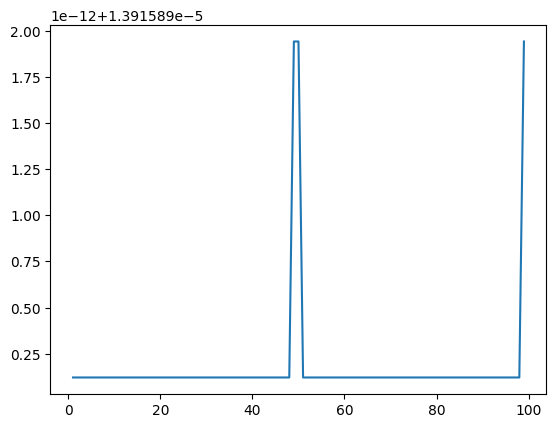

In [ ]:
plt.plot(range(100)[1:], [np.linalg.norm(embeddings_pca[i])for i in range(100)[1:]])

In [ ]:
pca_c

'13915875570.091885,5997.351053277366,5669.463162827348,-0.00877226363101466,0.002804785616276177,-0.003000953773289812,-0.000204889742597241,-0.0003295587597566593,-0.0006192882043322192,0.0001133603725112644,0.0007421820143489162,0.0004678361387634937,0.0004418198092338407,-0.0009638791364150457,0.0011110054092716367,-0.0003609507034427471,-0.0011058501095014765,0.00041469712563489805,0.00021817348775301837,-2.1386081037723696e-05,-0.00011445880374124947,0.0007818597486827653,0.0003091500685452623,-0.0011898944514714316,-0.0003964345286733758,0.00037663032554399603,0.00012597850869257508,-0.0001732971171397296,1.8048131000672336e-05,0.00013889718285488097,-0.0016546818609909962,-2.4105136802284873e-05,-0.0011508575236183697,0.0012923409771312773,-0.0066169891239067045,0.006041435612921389,0.0006400515750806424,0.0005653598541040948,8.015906170809633e-05,-0.0002410562244777732,0.00040767630093888356,-0.0017327594390098766,-0.0003317817818035014,0.0004308150759126177,-0.000184337819892